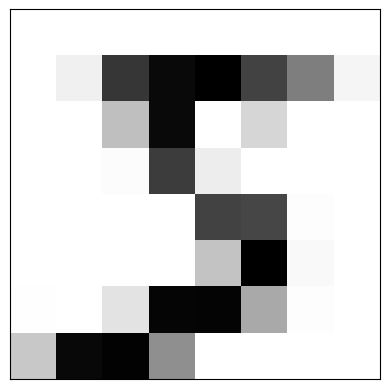

In [3]:
import MNIST_database as mnist
from matplotlib import pyplot as plt


#Choose the final size of your image dataset
size_final = 8

# data_zoom = mnist.MNISTData(size_initial=20, size_final=size_final, color_depth=5, flat=True)
data_zoom = mnist.MNISTData(size_initial=20, size_final=8, color_depth=8, flat=True)

x_train= data_zoom.x_train
y_train= data_zoom.y_train
x_test= data_zoom.x_test
y_test= data_zoom.y_test

# ax = plt.subplot(1, 1 , 1)
# plt.imshow(data_zoom.x_train[0].reshape(size_final,size_final), cmap='gray_r')
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow_model_optimization.python.core.quantization.keras.quantize import quantize_apply, quantize_annotate_layer
from tensorflow_model_optimization.python.core.quantization.keras.quantize_config import QuantizeConfig
from tensorflow_model_optimization.python.core.quantization.keras.quantize_scheme import QuantizeScheme
from tensorflow_model_optimization.python.core.quantization.keras.quantizers import LastValueQuantizer

# Set the random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Replace these with your own dataset
x_train = np.random.rand(1000, 64)
y_train = np.random.rand(1000, 32)

BIT_WIDTH = 8
input_shape = (x_train.shape[-1],)

def create_encoder_decoder_model(input_shape):
    inputs = Input(input_shape)
    x = quantize_annotate_layer(Dense(64, activation='relu'))(inputs)
    x = quantize_annotate_layer(Dense(32, activation='relu'))(x)
    x = quantize_annotate_layer(Dense(16, activation='relu'))(x)
    x = quantize_annotate_layer(Dense(2, activation='relu'))(x)
    x = quantize_annotate_layer(Dense(16, activation='relu'))(x)
    x = quantize_annotate_layer(Dense(32, activation='relu'))(x)
    outputs = quantize_annotate_layer(Dense(32, activation='linear'))(x)
    return Model(inputs, outputs)

model = create_encoder_decoder_model(input_shape)

class CustomQuantizeConfig(QuantizeConfig):
    def __init__(self, custom_quantize_config):
        self._quantize_config = custom_quantize_config

    def get_quantize_config(self, layer):
        return self._quantize_config
    
    def get_layout_transformer(self):
        return default_8bit_quantize_layout_transformer.Default8BitQuantizeLayoutTransformer()
    
    def get_quantize_registry(self):
        return default_8bit_quantize_registry.Default8BitQuantizeRegistry()
    def get_weights_and_quantizers(self, layer):
        return [(layer.kernel, LastValueQuantizer(num_bits=BIT_WIDTH, symmetric=True, narrow_range=False, per_axis=False))]

    def get_activations_and_quantizers(self, layer):
        return [(layer.activation, LastValueQuantizer(num_bits=BIT_WIDTH, symmetric=True, narrow_range=False, per_axis=False))]

    def set_quantize_weights(self, layer, quantize_weights):
        # Add this line for TensorFlow 2.6+
        layer.kernel = quantize_weights[0]

    def set_quantize_activations(self, layer, quantize_activations):
        layer.activation = quantize_activations[0]

    def get_output_quantizers(self, layer):
        return [LastValueQuantizer(num_bits=BIT_WIDTH, symmetric=True, narrow_range=False, per_axis=False)]

    def get_config(self):
        return {}

from tensorflow_model_optimization.python.core.quantization.keras.default_8bit import default_8bit_quantize_registry
from tensorflow_model_optimization.python.core.quantization.keras.default_8bit import default_8bit_quantize_layout_transformer


class CustomQuantizeScheme(QuantizeScheme):
    
# Apply quantization-aware training
with tf.keras.utils.CustomObjectScope(
    {'CustomQuantizeConfig': CustomQuantizeConfig}
):
    q_aware_model = quantize_apply(model, CustomQuantizeScheme(CustomQuantizeConfig()))

q_aware_model.compile(optimizer='adam', loss='mse')
q_aware_model.summary()

# Train the model
q_aware_model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1)

# Save and load the quantized model
q_aware_model.save('q_aware_model.h5')
with tf.keras.utils.CustomObjectScope(
    {'CustomQuantizeConfig': CustomQuantizeConfig}
):
    loaded_q_aware_model = load_model('q_aware_model.h5')

# Make predictions using the quantized model
predictions = loaded_q_aware_model.predict(x_train)

# Plot the first 5 predictions
for i in range(5):
    plt.figure()
    plt.plot(x_train[i], label='Input')
    plt.plot(predictions[i], label='Prediction')
    plt.legend()
    plt.show()


ImportError: cannot import name 'default_8bit_quantize_layout_transformer' from 'tensorflow_model_optimization.python.core.quantization.keras.default_8bit' (C:\Users\luisa\AppData\Roaming\Python\Python39\site-packages\tensorflow_model_optimization\python\core\quantization\keras\default_8bit\__init__.py)